# Setup

In [1]:
from sklearn.datasets import make_classification

import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')
# sns.set()
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [5]:
X = df.drop(columns='target')
y = df['target']
X.shape, y.shape

((303, 13), (303,))

In [6]:
X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'])
X_encoded.shape

(303, 23)

In [7]:
np.unique(y)

array([0, 1], dtype=int64)

In [8]:
y.value_counts()

1    165
0    138
Name: target, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, y_test.shape

((242, 23), (242,), (61,))

In [10]:
y_train.value_counts(sort=False)

0    109
1    133
Name: target, dtype: int64

In [11]:
# Doesn't need to scale
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [12]:
full_data = df.values
full_data.shape

(303, 14)

# Test Sklearn

In [13]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.819672131147541

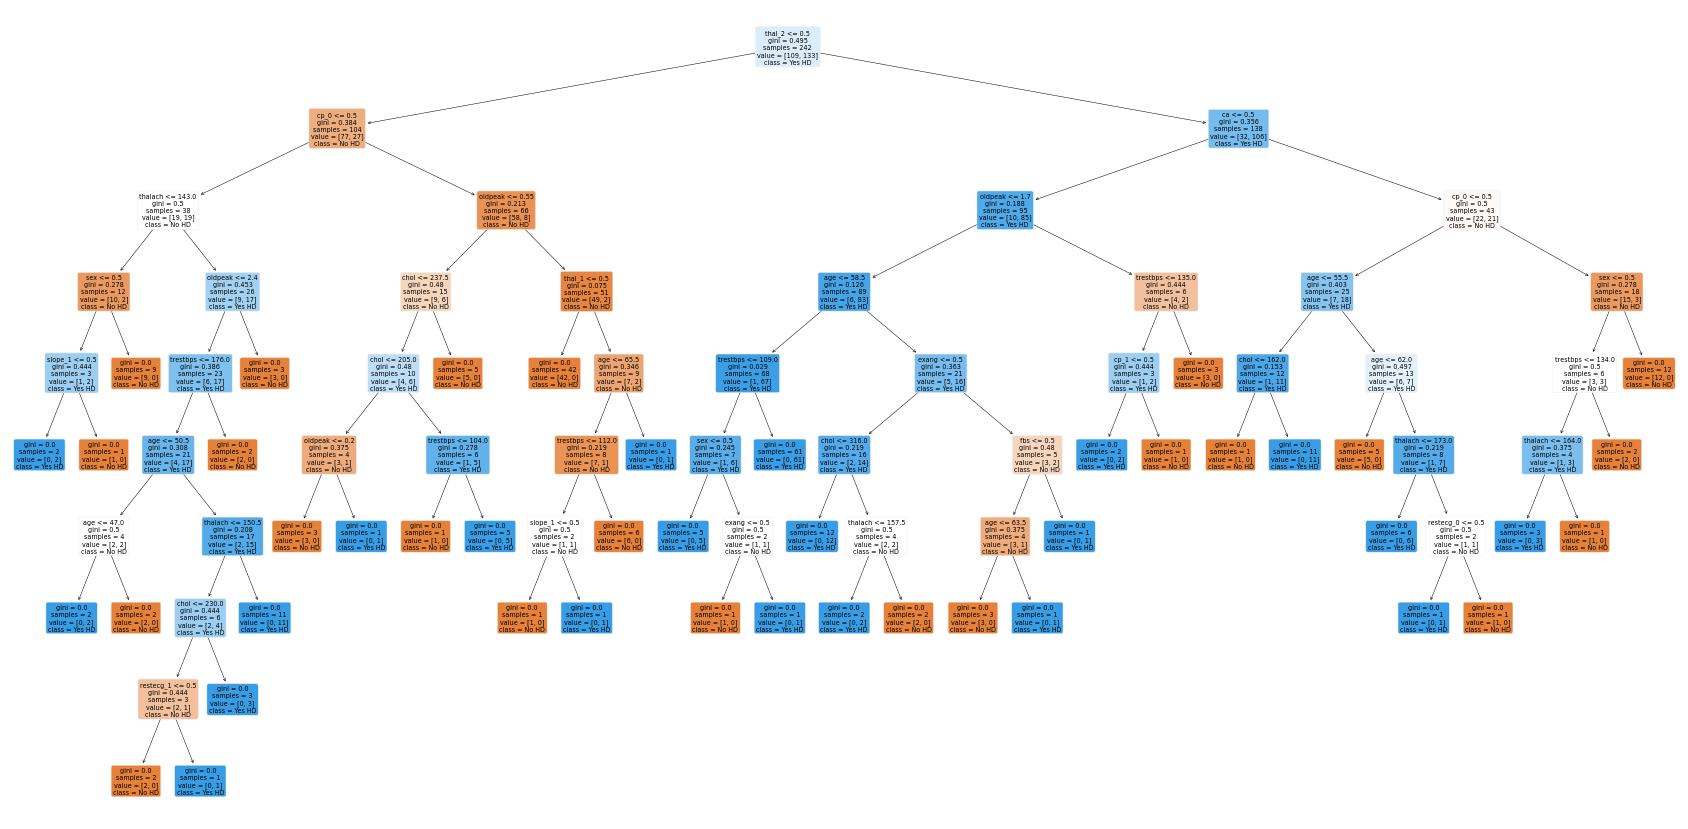

In [14]:
plt.figure(figsize=(30, 15))
plot_tree(clf, filled=True, rounded=True, class_names=['No HD', 'Yes HD'], feature_names=X_encoded.columns)
plt.show()

In [15]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_encoded.columns,  
                                class_names=['No HD', 'Yes HD'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)
# saved in hearts_decision_tree.pdf
graph.render('hearts_decision_tree')

'hearts_decision_tree.pdf'

# Implementation for DecisionTreeClassifier

In [34]:
S = np.array([1, 1, 1, 1, 1])
# np.square(np.bincount(S) / len(S))
counts = np.bincount(S)
if len(counts) == 1:
    counts = np.append(counts, 0)
print(counts)
np.argmax(counts)

[0 5]


1

In [17]:
X_arr = X.values
y_arr = y.values

classes = np.unique(y_arr.flatten())
n_classes = len(classes)

idx = 0
feature_col = X_arr[:, idx]
sorted_idxs = np.argsort(feature_col)
X_sorted = feature_col[sorted_idxs]
y_sorted = y_arr[sorted_idxs]

X_sorted.shape, y_sorted.shape

((303,), (303,))

In [18]:
def get_votes(y, thresh_idxs):
    y_thresh = y[thresh_idxs]
    votes = np.bincount(y_thresh)
    return votes

def get_gini_impurity(votes):
    total_votes = np.sum(votes)
    gini_impurity = 1 - np.sum(np.square(votes / total_votes))
    return gini_impurity

def _split(feature_col, threshold):
    left_idxs = np.where(feature_col <= threshold)[0]
    right_idxs = np.where(feature_col > threshold)[0]
    return left_idxs, right_idxs

In [19]:
# take midpoints of every other points as thresholds
thresholds = (X_sorted[:-1] + X_sorted[1:]) / 2
# for threshold in thresholds[5:6]:
threshold = thresholds[5]
left_idxs = np.where(feature_col <= threshold)[0]
right_idxs = np.where(feature_col > threshold)[0]
# thresh_idxs = (feature_col <= threshold)
y_left = y[left_idxs]
y_right = y[right_idxs]
votes_left = np.bincount(y_left)
votes_right = np.bincount(y_right)
print(votes_left, votes_right)

total_votes_left = np.sum(votes_left)
gini_left = 1 - np.sum(np.square(votes_left / total_votes_left))

total_votes_right = np.sum(votes_right)
gini_right = 1 - np.sum(np.square(votes_right / total_votes_right))

total_all_votes = total_votes_left + total_votes_right
total_gini = (total_votes_left / total_all_votes) * gini_left + \
                (total_votes_right / total_all_votes) * gini_right
print(total_gini)

[2 5] [136 160]
0.49466722734049473


REFACTORED:

In [20]:
# take midpoints of every other points as thresholds
thresholds = (X_sorted[:-1] + X_sorted[1:]) / 2
# for thresh in thresholds[5:6]:
threshold = thresholds[5]
left_idxs, right_idxs = _split(feature_col, threshold)
# thresh_idxs = (feature_col <= threshold)
votes_left, votes_right = get_votes(y, left_idxs), get_votes(y, right_idxs)
print(votes_left, votes_right)

gini_left, gini_right = get_gini_impurity(votes_left), get_gini_impurity(votes_right)

total_votes_left = np.sum(votes_left)
total_votes_right = np.sum(votes_right)
total_all_votes = total_votes_left + total_votes_right
total_gini = (total_votes_left / total_all_votes) * gini_left + \
                (total_votes_right / total_all_votes) * gini_right
print(total_gini)

[2 5] [136 160]
0.49466722734049473


In [21]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


In [22]:
class MyDecisionTreeClassifier:
    def __init__(self, max_depth=100, min_samples_split=2, max_features=None):
        # The maximum depth of the tree
        self.max_depth = max_depth
        # The minimum number of samples required to split an internal node
        self.min_samples_split = min_samples_split
        # The number of features to consider when looking for the best split
        self.max_features = max_features
        self.root = None
      
    def fit(self, X, y):
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values

        n_samples, n_features = X.shape
        if self.max_features:
            assert self.max_features <= n_features
        else:
            self.max_features = n_features

        self.root = self._grow_tree(X, y)

    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y.flatten()))

        # checking stopping criteria
        if (depth >= self.max_depth
            or n_classes == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._highest_voted_class(y)
            return Node(value=leaf_value)

        feature_idxs = np.random.choice(n_features, self.max_features, replace=False)

        # greedy search the best split
        best_feat, best_thresh = self._best_criteria(X, y, feature_idxs)
    
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left_branch = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right_branch = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left_branch, right_branch)

    def _highest_voted_class(self, y):
        counts = np.bincount(y)
        return np.argmax(counts)

    def _get_votes(self, y, thresh_idxs):
        y_thresh = y[thresh_idxs]
        votes = np.bincount(y_thresh)
        return votes

    def _get_gini(self, votes):
        total_votes = np.sum(votes)
        gini = 1 - np.sum(np.square(votes / total_votes))
        return gini

    def _split(self, feature_col, threshold):
        left_idxs = np.where(feature_col <= threshold)[0]
        right_idxs = np.where(feature_col > threshold)[0]
        return left_idxs, right_idxs

    def _total_gini_impurity(self, y, feature_col, threshold):
        left_idxs, right_idxs = self._split(feature_col, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
            
        votes_left, votes_right = self._get_votes(y, left_idxs), self._get_votes(y, right_idxs)

        gini_left, gini_right = self._get_gini(votes_left), self._get_gini(votes_right)

        total_votes_left = np.sum(votes_left)
        total_votes_right = np.sum(votes_right)
        total_all_votes = total_votes_left + total_votes_right
        total_gini = (total_votes_left / total_all_votes) * gini_left + \
                        (total_votes_right / total_all_votes) * gini_right
        return total_gini

    def _best_criteria(self, X, y, feature_idxs):
        best_gini = np.inf
        for feature_idx in feature_idxs:
            feature_col = X[:, feature_idx]
            X_sorted = np.sort(feature_col)
            # take midpoints of every other points as thresholds
            thresholds = (X_sorted[:-1] + X_sorted[1:]) / 2
            for threshold in thresholds:
                total_gini = self._total_gini_impurity(y, feature_col, threshold)

                if total_gini < best_gini:
                    best_gini = total_gini
                    split_idx = feature_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [23]:
clf = MyDecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)

ValueError: attempt to get argmax of an empty sequence

In [27]:
from collections import Counter

def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [ ]:
# from sklearn import datasets
# data = datasets.load_breast_cancer()
# X, y = data.data, data.target

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=1234
# )
# X_train.shape, y_train.shape

((455, 30), (455,))

In [30]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy:", acc)